<a href="https://colab.research.google.com/github/johnkidsm/ML-scripts/blob/main/multi_agent_collaboration_with_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


In [19]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [20]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [21]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [22]:
import functools

from langchain_core.messages import AIMessage
from openai import OpenAI

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o", openai_api_base="https://api.gptsapi.net/v1",
    openai_api_key="sk-SCad4f2e0c1b3f597d8a0bebabcc37943e42d9a023eVBQ93")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [23]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [24]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [25]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

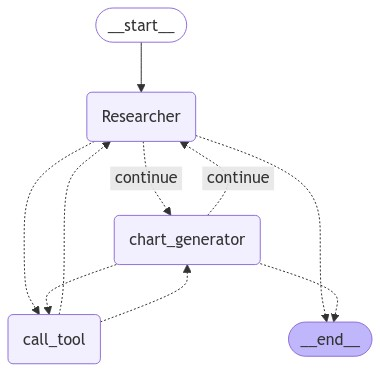

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_I8mV4keu0mk7J1rVBtFUd2il', 'function': {'arguments': '{"query":"UK GDP data for the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 217, 'total_tokens': 243, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_67802d9a6d', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-27338f2c-3910-4b36-b99c-8a256e8ddb71-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data for the past 5 years'}, 'id': 'call_I8mV4keu0mk7J1rVBtFUd2il', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 26, 'total_tokens': 243, 'input_token_details': {}, 'output_token_details': {}})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages'

{'Researcher': {'messages': [AIMessage(content="It seems I made an error in attempting to use the chart generator tool, which isn't available. I will now proceed to use a different approach to draw the line graph.", additional_kwargs={'tool_calls': [{'id': 'call_O10aT22qHLWT6HF9wbU0iCrY', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for the UK\'s GDP over the past 5 years\\nyears = [2018, 2019, 2020, 2021, 2022]\\ngdp_values = [2864.0, 2850.05, 2697.81, 3141.51, 3088.84]\\n\\n# Plotting the graph\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 207, 'prompt_tokens': 2944, 'total_tokens': 3151, 'completion_tokens_details': None, 'prompt_tokens_details

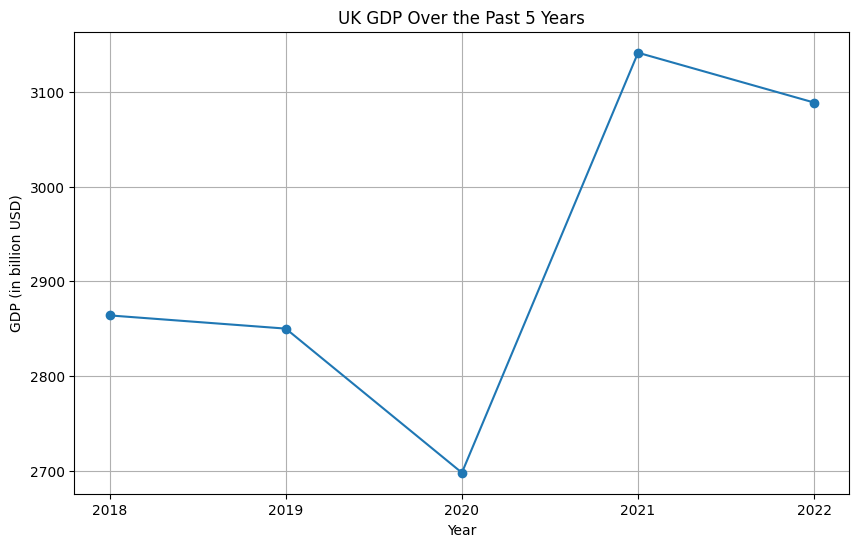

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Data for the UK's GDP over the past 5 years\nyears = [2018, 2019, 2020, 2021, 2022]\ngdp_values = [2864.0, 2850.05, 2697.81, 3141.51, 3088.84]\n\n# Plotting the graph\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker='o')\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.grid(True)\nplt.xticks(years)\nplt.show()\n\\`\\`\\`\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_O10aT22qHLWT6HF9wbU0iCrY')]}}
----
{'Researcher': {'messages': [AIMessage(content="The line graph depicting the UK's GDP over the past 5 years has been successfully generated. \n\nFINAL ANSWER", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 3342, 'total_tokens': 3365, 'completion_tokens_details':

In [28]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")